In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
img_array = cv2.imread("../datasets/FER_2013/train/angry/Training_3908.jpg")

In [3]:
img_array.shape

(48, 48, 3)

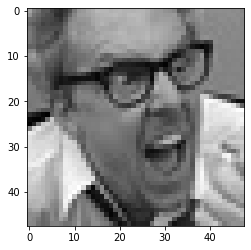

In [4]:
plt.imshow(img_array)

In [5]:
data_dir = "../datasets/FER_2013/train/"
test_data_dir = "../datasets/FER_2013/test/"

In [6]:
classes = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

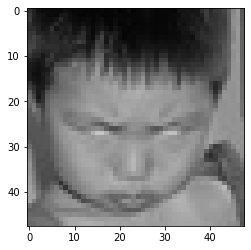

In [7]:
for category in classes:
    path = os.path.join(data_dir, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB))
        plt.show()
        break
    break

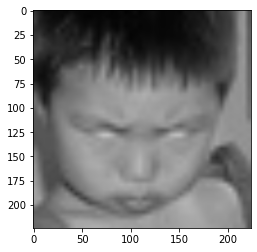

In [8]:
img_size = 224
new_array = cv2.resize(img_array, (img_size, img_size))
plt.imshow(cv2.cvtColor(new_array,cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
new_array.shape

(224, 224, 3)

In [10]:
training_data = []

def create_training_data():
    for category in classes:
        path = os.path.join(data_dir, category)
        class_num = classes.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array,(img_size, img_size))
                training_data.append([new_array, class_num])
            except Exception as e: 
                pass

In [11]:
create_training_data()
print(len(training_data))

28709


In [12]:
test_data = []

def create_test_date():
    for category in classes:
        path = os.path.join(test_data_dir, category)
        class_num = classes.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array,(img_size, img_size))
                test_data.append([new_array, class_num])
            except Exception as e: 
                pass
    

In [13]:
create_test_date()
print(len(test_data))

7178


In [14]:
import random
random.shuffle(training_data)

In [15]:
x = []
y = []

for features, label in training_data:
    x.append(features)
    y.append(label)
    
x = np.array(x).reshape(-1, img_size, img_size, 3)

test_images = []
test_labels = []
for features, label in test_data:
    test_images.append(features)
    test_labels.append(label)
    
test_images = np.array(test_images).reshape(-1, img_size, img_size, 3)


In [16]:
x.shape
test_images.shape

(7178, 224, 224, 3)

In [17]:
x = x/255.0

In [18]:
y = np.array(y)
test_labels = np.array(test_labels)

In [19]:
test_labels.shape

(7178,)

In [20]:
from keras.utils import to_categorical
y = to_categorical(y)
test_labels = to_categorical(test_labels)

In [21]:
y[0]

array([0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

In [23]:
model = models.Sequential()
model.add(layers.Conv2D(224, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(7))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#history = model.fit(x, y, epochs=10,validation_data=(test_images, test_labels))

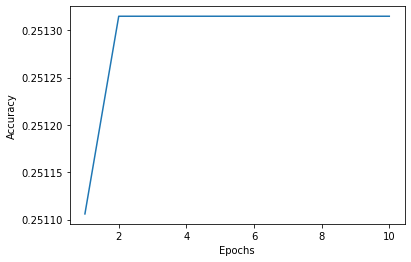

In [41]:
all_mae_histories = []
mae_history = history.history['accuracy']
all_mae_histories.append(mae_history)
average_mae_history = [np.mean([x[i] for x in all_mae_histories])for i in range(10)]

import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [24]:
model.summary()
model.save('initial_1.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 224)     6272      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 224)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      129088    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 173056)            0

# Scaling up the model 

In [24]:
base_input = model.layers[0].input
base_output = model.layers[-2].output

In [25]:
final_output = layers.Dense(128)(base_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(64)(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(7, activation='softmax')(final_output)

In [28]:
scaled_model = keras.Model(inputs = base_input, outputs = final_output)
scaled_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 224)     6272      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 224)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      129088    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        3692

In [31]:
scaled_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = scaled_model.fit(x, y, epochs=10,validation_data=(test_images, test_labels))

Epoch 1/10
898/898 [==============================] - 4084s 5s/step - loss: 1.7280 - accuracy: 0.2995 - val_loss: 120.6911 - val_accuracy: 0.2816
Epoch 2/10
898/898 [==============================] - 4153s 5s/step - loss: 1.5279 - accuracy: 0.4040 - val_loss: 80.8776 - val_accuracy: 0.3651
Epoch 3/10
898/898 [==============================] - 4059s 5s/step - loss: 1.3783 - accuracy: 0.4724 - val_loss: 97.7099 - val_accuracy: 0.3867
Epoch 4/10
898/898 [==============================] - 4152s 5s/step - loss: 1.1799 - accuracy: 0.5556 - val_loss: 158.9740 - val_accuracy: 0.3643
Epoch 5/10
898/898 [==============================] - 4097s 5s/step - loss: 0.9005 - accuracy: 0.6642 - val_loss: 288.5673 - val_accuracy: 0.3412
Epoch 6/10
898/898 [==============================] - 4232s 5s/step - loss: 0.5946 - accuracy: 0.7854 - val_loss: 405.8852 - val_accuracy: 0.3664
Epoch 7/10
898/898 [==============================] - 4193s 5s/step - loss: 0.3568 - accuracy: 0.8759 - val_loss: 662.4429 - v

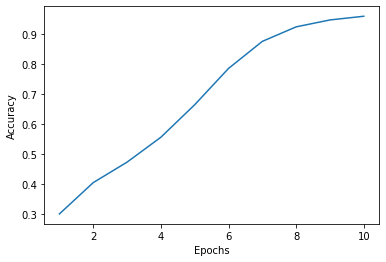

In [32]:
all_mae_histories = []
mae_history = history.history['accuracy']
all_mae_histories.append(mae_history)
average_mae_history = [np.mean([x[i] for x in all_mae_histories])for i in range(10)]

import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [36]:
scaled_model.summary()
scaled_model.save('scaled_model_1.h5')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 224)     6272      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 224)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      129088    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        3692

# Adding Dropout

In [43]:
from tensorflow.keras.layers import Dropout
base_input = model.layers[0].input
base_output = model.layers[-2].output

In [49]:
final_output = layers.Dense(128)(base_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dropout(0.2)(final_output)
final_output = layers.Dense(64)(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(7, activation='softmax')(final_output)

In [50]:
regularized_model = keras.Model(inputs = base_input, outputs = final_output)
regularized_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 224)     6272      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 224)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      129088    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        3692

In [51]:
regularized_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = regularized_model.fit(x, y, epochs=10,validation_data=(test_images, test_labels))

Epoch 1/10
898/898 [==============================] - 4727s 5s/step - loss: 0.2991 - accuracy: 0.8993 - val_loss: 700.1165 - val_accuracy: 0.3605
Epoch 2/10
898/898 [==============================] - 4266s 5s/step - loss: 0.1414 - accuracy: 0.9540 - val_loss: 681.2671 - val_accuracy: 0.3555
Epoch 3/10
898/898 [==============================] - 4250s 5s/step - loss: 0.1243 - accuracy: 0.9627 - val_loss: 848.1249 - val_accuracy: 0.3576
Epoch 4/10
898/898 [==============================] - 4276s 5s/step - loss: 0.1034 - accuracy: 0.9708 - val_loss: 850.7083 - val_accuracy: 0.3512
Epoch 5/10
898/898 [==============================] - 4646s 5s/step - loss: 0.0946 - accuracy: 0.9724 - val_loss: 1103.7334 - val_accuracy: 0.3068
Epoch 6/10
898/898 [==============================] - 4696s 5s/step - loss: 0.0874 - accuracy: 0.9741 - val_loss: 919.7676 - val_accuracy: 0.3500
Epoch 7/10
898/898 [==============================] - 4490s 5s/step - loss: 0.0784 - accuracy: 0.9780 - val_loss: 1109.7172

In [52]:
regularized_model.summary()
regularized_model.save('regularized_model_1.h5')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 224)     6272      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 224)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      129088    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        3692

# Add L2 regularization

In [57]:
from keras import regularizers
base_input = model.layers[0].input
base_output = model.layers[-2].output

In [58]:
final_output = layers.Dense(128)(base_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dropout(0.2)(final_output)
final_output = layers.Dense(64, kernel_regularizer=regularizers.l2(0.0001))(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(7, activation='softmax')(final_output)

In [59]:
regularized_l2_model = keras.Model(inputs = base_input, outputs = final_output)
regularized_l2_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 224)     6272      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 224)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      129088    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        3692

In [60]:
regularized_l2_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = regularized_l2_model.fit(x, y, epochs=10,validation_data=(test_images, test_labels))

Epoch 1/10
898/898 [==============================] - 5490s 6s/step - loss: 0.2108 - accuracy: 0.9368 - val_loss: 974.7734 - val_accuracy: 0.3352
Epoch 2/10
898/898 [==============================] - 4355s 5s/step - loss: 0.0917 - accuracy: 0.9759 - val_loss: 1085.5696 - val_accuracy: 0.3395
Epoch 3/10
898/898 [==============================] - 4368s 5s/step - loss: 0.0753 - accuracy: 0.9804 - val_loss: 1016.4065 - val_accuracy: 0.3511
Epoch 4/10
898/898 [==============================] - 4368s 5s/step - loss: 0.0656 - accuracy: 0.9829 - val_loss: 1198.9519 - val_accuracy: 0.3534
Epoch 5/10
898/898 [==============================] - 4361s 5s/step - loss: 0.0675 - accuracy: 0.9821 - val_loss: 1052.3593 - val_accuracy: 0.3452
Epoch 6/10
898/898 [==============================] - 4255s 5s/step - loss: 0.0598 - accuracy: 0.9850 - val_loss: 1145.5231 - val_accuracy: 0.3502
Epoch 7/10
898/898 [==============================] - 4082s 5s/step - loss: 0.0580 - accuracy: 0.9855 - val_loss: 1060.

In [61]:
regularized_l2_model.summary()
regularized_l2_model.save('regularized_l2_model_1.h5')

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 224)     6272      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 224)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      129088    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        3692

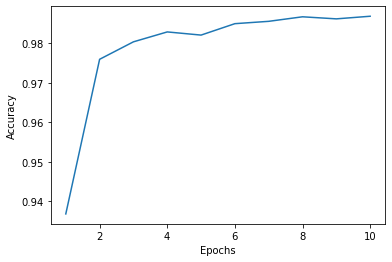

In [62]:
all_mae_histories = []
mae_history = history.history['accuracy']
all_mae_histories.append(mae_history)
average_mae_history = [np.mean([x[i] for x in all_mae_histories])for i in range(10)]

import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [63]:
base_input = model.layers[0].input
base_output = model.layers[-2].output

In [64]:
final_output = layers.Dense(128)(base_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dropout(0.2)(final_output)
final_output = layers.Dense(64, kernel_regularizer=regularizers.l2(0.0001))(final_output)
final_output = layers.Dense(64, kernel_regularizer=regularizers.l2(0.0001))(final_output)
final_output = layers.Dense(64, kernel_regularizer=regularizers.l2(0.0001))(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(7, activation='softmax')(final_output)

In [65]:
final_model = keras.Model(inputs = base_input, outputs = final_output)
final_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 224)     6272      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 224)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      129088    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        3692

In [66]:
final_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = final_model.fit(x, y, epochs=10,validation_data=(test_images, test_labels))

Epoch 1/10
898/898 [==============================] - 5592s 6s/step - loss: 0.1786 - accuracy: 0.9514 - val_loss: 1221.2645 - val_accuracy: 0.3314
Epoch 2/10
898/898 [==============================] - 4328s 5s/step - loss: 0.0838 - accuracy: 0.9809 - val_loss: 1168.5475 - val_accuracy: 0.3200
Epoch 3/10
898/898 [==============================] - 4300s 5s/step - loss: 0.0794 - accuracy: 0.9825 - val_loss: 1196.0580 - val_accuracy: 0.3408
Epoch 4/10
898/898 [==============================] - 4704s 5s/step - loss: 0.0757 - accuracy: 0.9848 - val_loss: 1170.7339 - val_accuracy: 0.3374
Epoch 5/10
898/898 [==============================] - 4712s 5s/step - loss: 0.0714 - accuracy: 0.9848 - val_loss: 1286.7987 - val_accuracy: 0.3385
Epoch 6/10
898/898 [==============================] - 4703s 5s/step - loss: 0.0690 - accuracy: 0.9859 - val_loss: 1127.2917 - val_accuracy: 0.3233
Epoch 7/10
898/898 [==============================] - 4702s 5s/step - loss: 0.0649 - accuracy: 0.9866 - val_loss: 1127

In [69]:
final_model.summary()
final_model.save('final_model.h5')

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 224)     6272      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 224)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      129088    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        3692

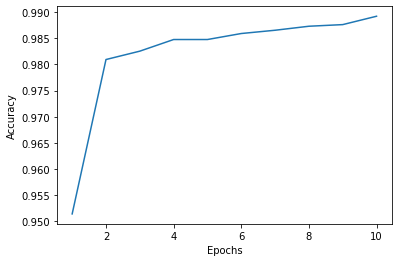

In [67]:
all_mae_histories = []
mae_history = history.history['accuracy']
all_mae_histories.append(mae_history)
average_mae_history = [np.mean([x[i] for x in all_mae_histories])for i in range(10)]

import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [70]:
new_model = tf.keras.models.load_model('final_model.h5')
frame = cv2.imread("Happy-child-1424x802.jpg")

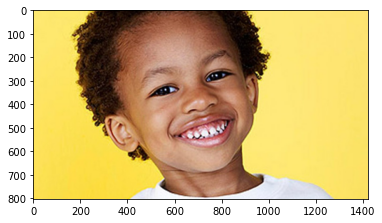

In [71]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [72]:
frame.shape

(802, 1424, 3)

In [73]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
assert not faceCascade.empty()
faceCascade.empty()

False

In [74]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [75]:
gray.shape
type(gray[1])

numpy.ndarray

In [76]:
import numpy as np
gray = np.array(gray, dtype='uint8')
gray.dtype

dtype('uint8')

In [77]:
#faces = faceCascade.detectMultiScale(gray,1,1,4)
faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(1,1),
    flags = cv2.CASCADE_SCALE_IMAGE
)
for x,y,w,h in faces:
    roi_gray = gray[y:y+h,x:x+w]
    roi_color = frame[y:y+h,x:x+w]
    cv2.rectangle(frame, (x, y), (x+w, y+w), (255, 0, 0), 2)
    facess = faceCascade.detectMultiScale(roi_gray)
    if len(facess) == 0:
        print("Face not detected")
    else:
        for (ex, ey, ew, eh) in facess:
            face_roi = roi_color[ey: ey+eh, ex:ex+ew]

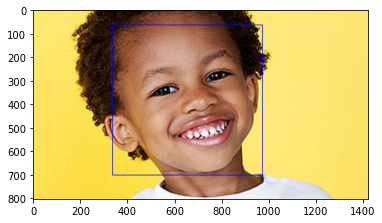

In [78]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

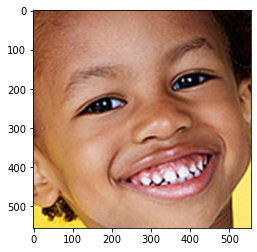

In [79]:
plt.imshow(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))

In [80]:
final_image = cv2.resize(face_roi, (224, 224))
final_image = np.expand_dims(final_image, axis=0)
final_image = final_image/255.0

In [91]:
print(classes)
predictions = new_model.predict(final_image)
print(classes[np.argmax(predictions[0])])
#tf.nn.softmax(predictions[0])

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
1/1 [==============================] - 0s 59ms/step
happy


In [48]:
import cv2 # pip install opencv-python
#pip install opencv-contrib-python full package
#from deepface import DeepFace #pip install deepface
path = "haarcascade_frontalface_default.xml"
font_scale = 1.5
font = cv2.FONT_HERSHEY_PLAIN#set the rectangle background to white
rectangle_bgr = (255, 255, 255)
#make a black image
img = np.zeros((500, 500))
#set some text
text = "Some text in a box!"
# get the width and height of the text box
(text_width, text_height) = cv2.getTextSize(text, font, fontScale=font_scale, thickness=1)[0]
# set the text start position
text_offset_x = 10
text_offset_y = img.shape[0] - 25
#make the coords of the box with a small padding of two pixels
box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height - 2))
cv2.rectangle(img, box_coords[0], box_coords[1], rectangle_bgr, cv2.FILLED)
cv2.putText(img, text, (text_offset_x, text_offset_y), font, fontScale=font_scale, color=(0, 0, 0), thickness=1)
cap = cv2.VideoCapture(1)
# Check if the webcam is opened correctly
if not cap.isOpened():
    cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open webcam")
while True:
    ret, frame = cap.read()
    #eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #print(faceCascade.empty())
    #faces = faceCascade.detectMultiScale(gray,1.1,4)
    faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(1,1),
    flags = cv2.CASCADE_SCALE_IMAGE
)
    for x,y,w,h in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        facess = faceCascade.detectMultiScale(roi_gray)
        if len(facess) == 0:
          print("Face not detected")
        else:
          for (ex,ey,ew,eh) in facess:
            face_roi = roi_color[ey: ey+eh, ex:ex + ew] ## cropping the face

    final_image = cv2.resize(face_roi, (224,224))
    final_image = np.expand_dims(final_image,axis=0) ## need fourth dimension
    final_image = final_image/255.0
    font = cv2.FONT_HERSHEY_SIMPLEX
    Predictions = new_model.predict(final_image)
    font_scale = 1.5
    font = cv2.FONT_HERSHEY_PLAIN
    if(np.argmax(Predictions)==0):
        status = "Angry"
        x1,y1,w1,h1 = 0,0,175,75
        #Draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0,0,0), -1)
        #Addd text
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
        cv2.putText(frame, status,(100,150),font, 3,(0, 0, 255),2,cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 0, 255))
    elif (np.argmax(Predictions)==1):
        status = "Disgust"
        x1,y1,w1,h1 = 0,0,175,75
        #Draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0,0,0), -1)
        #Addd text
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
        cv2.putText(frame, status,(100,150),font, 3,(0, 0, 255),2,cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 0, 255))
    elif (np.argmax(Predictions)==2):
        status = "Fear"
        x1,y1,w1,h1 = 0,0,175,75
        #Draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0,0,0), -1)
        #Addd text
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
        cv2.putText(frame, status,(100,150),font, 3,(0, 0, 255),2,cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 0, 255))

    elif (np.argmax(Predictions)==3):
        status = "Happy"
        x1,y1,w1,h1 = 0,0,175,75
        #Draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0,0,0), -1)
        #Addd text
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
        cv2.putText(frame, status,(100,150),font, 3,(0, 0, 255),2,cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 0, 255))
    elif (np.argmax(Predictions)==4):
        status = "Sad"
        x1,y1,w1,h1 = 0,0,175,75
        #Draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0,0,0), -1)
        #Addd text
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
        cv2.putText(frame, status,(100,150),font, 3,(0, 0, 255),2,cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 0, 255))
    elif (np.argmax(Predictions)==5):
        status = "Surprise"
        x1,y1,w1,h1 = 0,0,175,75
        #Draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0,0,0), -1)
        #Addd text
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
        cv2.putText(frame, status,(100,150),font, 3,(0, 0, 255),2,cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 0, 255))
    else:
        status = "Neutral"
        x1,y1,w1,h1 = 0,0,175,75
        #Draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0,0,0), -1)
        #Addd text
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
        cv2.putText(frame, status,(100,150),font, 3,(0, 0, 255),2,cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 0, 255))
    cv2.imshow('Face Emotion Recognition', frame)
    if cv2.waitKey(2) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 111ms/step


Alert ! Camera disconnected
